# Segmentation methodology for Chameleon

In [1]:
from inference_pipeline import heuristic
# This code has been tested on Python 3.11.7
! pip install -r requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
from tqdm.auto import tqdm

from CNN.train import train
from inference_pipeline.sliding_window_classification import getModule, classifyTrace, saveClassification
from inference_pipeline.segmentation import *
from CNN.build_dataset_chameleon import createSubsets
from inference_pipeline.debug import *
from matplotlib import pyplot as plt
from inference_pipeline.heuristic import removeFalseNegatives, removeFalsePositives, removeFalsePositives_basic

D:\Neu Aufsetzen\Studium\11. Semester\AdvSecRes\.venv\Lib\site-packages\lightning_fabric\__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


## CNN dataset creation

In [3]:
chameleon_path = "datasets/" + "BASE" + "/" # Patterns: BASE DFS RD MRP CHF
dataset_out_path = "temporary_files"

In [4]:
createSubsets(chameleon_path, dataset_out_path, reuse_existing_dataset=True)

## CNN training

Each CNN is configure thanks to a YALM configuration file.  
You can set different module hyper-parameters as well as the dataset, the logger, and the experiment configurations.  
Default configuration are in `CNN/configs` directory, both for Neputune logger and for the experiment. 

> Some mandatory YALM parameters must be set for each experiment.  
> - Set `log_dir` in the `experiment.yaml` files.  
> - Set `dataset_dir` in the `data.yaml` files to the output folder used by `createSubsets()`.  

> Neptune logging and Neptune.ai account are optional and can be enabled or disabled as desired.

In [ ]:
#config_folder = "CNN/configs/chameleon_base/" # /path/to/experiment/config/folder/
#train(config_folder)

## Sliding Window Classification

It is best to restart the jupyter server here, as the traing data might use up memory required for the inference

In [1]:
import importlib
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

from unsupervised_learning.unsupervised_sliding_windows_classification import classifyTrace_unsupervised, saveClassification
from inference_pipeline.segmentation import *
from inference_pipeline.debug import *

import inference_pipeline.heuristic as heuristic
importlib.reload(heuristic)
import unsupervised_learning.vectorization as vectorization
importlib.reload(vectorization)
import unsupervised_learning.classification as classification
importlib.reload(classification)

D:\Neu Aufsetzen\Studium\11. Semester\AdvSecRes\.venv\Lib\site-packages\lightning_fabric\__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


<module 'unsupervised_learning.classification' from 'D:\\Neu Aufsetzen\\Studium\\11. Semester\\AdvSecRes\\unsupervised_learning\\classification.py'>

In [2]:
dataset = 'BASE'
chunk = 1

chameleon_file = f"datasets/{dataset}/chameleon_base_chunk_{chunk}.h5"
output_file = "temporary_files/output_file.npy"

vectorizer = vectorization.TSFreshVectorizer(fc_params="minimal", n_jobs=9)
classifier = classification.KMeansClassifier()  # 3 clusters, size-ordered classes 0/1/2

Compute and save segmentation as file `output_file`.
Function _classifyTrace_ has a few parameters to configure based on the experiment:

- `stride`: Define the stride to use for the sliding window.
- `window_size`: Define the size of the sliding window itself.

In [3]:
window_size = 10_000
stride = 300 #50

In [4]:
#classifications = classifyTrace(chameleon_file, module, stride, window_size, batch_size=256)
#saveClassification(classifications, output_file)

scores = classifyTrace_unsupervised(
    trace_file=chameleon_file,
    vectorizer=vectorizer,
    classifier=classifier,
    stride=stride,
    window_size=window_size,
    batch_size=22500,
)
"""
Geschätze Zeit nach 3 Batches/Am Ende:
5000, 25000, 10: 7:53
5000, 22500, 10: 7:41
5000, 20000, 10: 7:52

5000, 22500, 6: 7:39
5000, 22500, 7: 7:34
5000, 22500, 8: 7:28

500, 22500, 8: 1:17:00
5000, 22500, 7, Eff: 9:04
5000, 22500, 8, Eff: 9:02
5000, 22500, 9, Eff: 8:59
"""

saveClassification(scores, output_file)

  0%|          | 0/16 [00:00<?, ?it/s]

## Screening

Compute the segmenation and find the starting sample of each cryptographic operation.

In [5]:
classification_file = output_file#"temporary_files/classification_output_file"

labels = loaderGt(chameleon_file)
classifications = np.load(classification_file, mmap_mode='r')

gts_starts = []
gts_ends = []
for label in labels:
    gts_starts.append(label['start'])
    gts_ends.append(label['end'])

init_min_distance = 150_000

In [6]:
major_filter_size = 150
CPs = []

for classification, gt, gt_e in tqdm(zip(classifications, gts_starts, gts_ends), total=len(classifications)):
    CPs.append(segment(classification, major_filter_size, stride, init_min_distance))

  0%|          | 0/16 [00:00<?, ?it/s]

Remove false positive and false negatives from the identified COs

In [7]:
starts = []
ends = []

for idx in tqdm(range(len(CPs))):
    s, e = heuristic.removeFalsePositives_basic(CPs[idx]['starts'], CPs[idx]['ends'])
    s, e = heuristic.removeFalseNegatives(s, e, classifications[idx])
    starts.append(s)
    ends.append(e)

  0%|          | 0/16 [00:00<?, ?it/s]

In [8]:
fnrs_s, fprs_s = [],[]
fnrs_e, fprs_e = [],[]

for idx in tqdm(range(len(CPs))):
    fpr, fnr = errorRate(gts_starts[idx], np.asarray(starts[idx]), stride)
    fprs_s.append(fpr)
    fnrs_s.append(fnr)
    fpr, fnr = errorRate(gts_ends[idx], np.asarray(ends[idx]), stride)
    fprs_e.append(fpr)
    fnrs_e.append(fnr)
    
print(f"Total start mean FPR: {round(np.mean(fprs_s)*100,2)}%")
print(f"Total start mean FNR: {round(np.mean(fnrs_s)*100,2)}%")
print(f"Total end mean FPR: {round(np.mean(fprs_e)*100,2)}%")
print(f"Total end mean FNR: {round(np.mean(fnrs_e)*100,2)}%")

  0%|          | 0/16 [00:00<?, ?it/s]

Total start mean FPR: 18.79%
Total start mean FNR: 22.1%
Total end mean FPR: 17.83%
Total end mean FNR: 21.25%


## Visualization

Visualize the detected COs and ground truth (GT) for a given trace.

**First Subplot**: Draws black vertical lines for detected COs' _starts_ and red dashed vertical lines for GT.  
**Second Subplot**: Draws grey vertical lines for detected COs' _ends_ and yellow dashed vertical lines for GT.  
**Third Subplot**: Plots classification for each point in the trace.

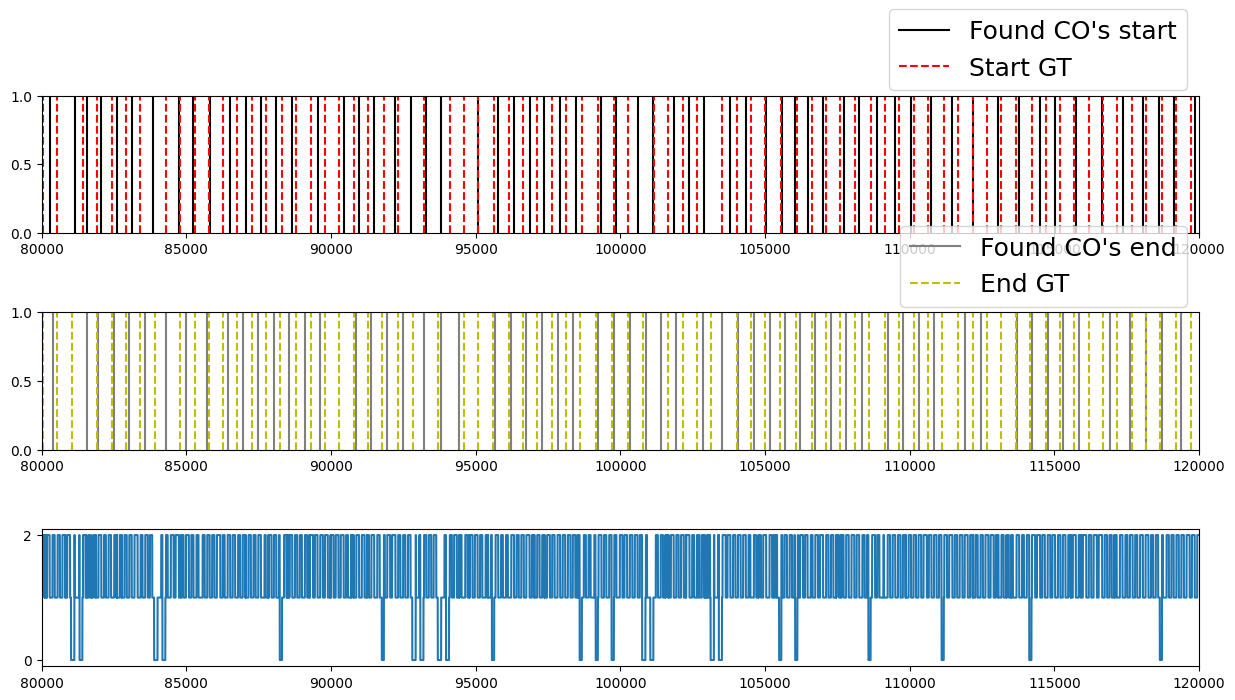

In [9]:
n_trace = 0
center = 100_000
margin = 20_000
lim = (center-margin, center+margin)

fig, ax = plt.subplots(3, figsize=(13, 7))
plt.rcParams.update({'font.size': 18})
fig.tight_layout(pad=2.0)

ax[0].set_xlim(lim)
for sample in starts[n_trace][1:]:
    ax[0].axvline(x=sample, color='black', linestyle='-')
ax[0].axvline(x=starts[n_trace][0], color='black', linestyle='-', label="Found CO's start")

for sample in gts_starts[n_trace][1:]:
    ax[0].axvline(x=sample//stride, color='r', linestyle='--')
ax[0].axvline(x=gts_starts[n_trace][0]//stride, color='r', linestyle='--', label='Start GT')
ax[0].legend(loc='lower right', bbox_to_anchor=(1, 0.95))


ax[1].set_xlim(lim)
for sample in ends[n_trace][1:]:
    ax[1].axvline(x=sample, color='grey', linestyle='-')
ax[1].axvline(x=ends[n_trace][0], color='grey', linestyle='-', label="Found CO's end")

for sample in gts_ends[n_trace][1:]:
    ax[1].axvline(x=sample//stride, color='y', linestyle='--')
ax[1].axvline(x=gts_ends[n_trace][0]//stride, color='y', linestyle='--', label='End GT')
ax[1].legend(loc='lower right', bbox_to_anchor=(1, 0.95))


ax[2].set_xlim(lim)
ax[2].plot(np.argmax(classifications[n_trace], axis=1))
def removeFalsePositives_basic(COstarts: list, COends: list) -> tuple:
    """
    Remove false positives from identified COs (basic implementation).
    """

    starts, ends = [], []
    i, j = 0, 0

    # We need at least one "next" element for both lists to run the core heuristic
    while i < len(COstarts) - 1 and j < len(COends) - 1:
        # Always safe here: i < len(COstarts)
        starts.append(COstarts[i])

        # ---- decide how to advance i, but guard i+1 ----
        has_next_start = (i + 1 < len(COstarts))
        if has_next_start and COstarts[i] < COends[j] and COstarts[i + 1] >= COends[j]:
            i += 1
        else:
            i += 2

        # We may have moved i past the end; if so, we can't safely use COstarts[i] anymore
        if i >= len(COstarts):
            # No more valid starts to compare with; we just stop using the heuristic
            break

        # ---- process ends and decide how to advance j, but guard j+1 ----
        ends.append(COends[j])

        has_next_end = (j + 1 < len(COends))
        if has_next_end and COstarts[i] >= COends[j] and COstarts[i] < COends[j + 1]:
            j += 1
        else:
            j += 2

        # If we moved j too far, the while condition will stop us on the next iteration

    # Append any remaining starts/ends that were not processed by the loop
    if i < len(COstarts):
        starts.extend(COstarts[i:])
    if j < len(COends):
        ends.extend(COends[j:])

    return starts, ends